# Experiments Notebooks
These experiments have been ran on a GPU cluster. Some models, especially Deep Learning architectures, are computationally heavy and take hours to complete.
For this reason, the cells below run the best configuration of each model for the tab classification task. 


In [1]:
from experiments.run_experiments import *

## Baseline Experiments - Model-based AI

Class-distributed sample set used in original experiment:  77
Precision Micro: 0.753247
Precision Macro: 0.789177
Precision Weighted: 0.789177
Recall Macro: 0.753247
Recall Micro: 0.753247
Recall Weighted: 0.753247
F1 score Weighted: 0.742721
F1 score Macro: 0.742721
F1 score Micro: 0.753247


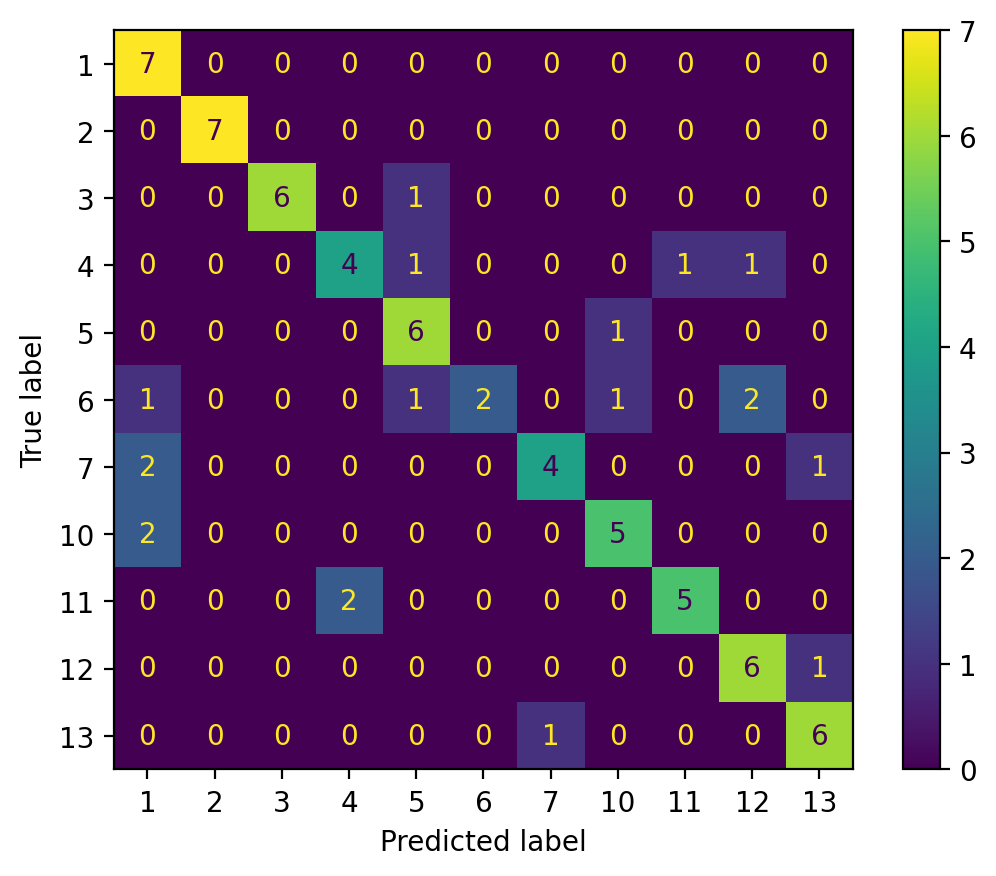

In [3]:
# Taken from confusion matrix of: "An Open Corpus for Arab-Andalusian Music"
actual = [1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4,5,5,5,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,7,7,7,10,10,10,10,10,10,10,11,11,11,11,11,11,11,12,12,12,12,12,12,12,13,13,13,13,13,13,13]
pred =   [1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,5,4,4,4,4,5,11,12,5,5,5,5,5,5,10,1,5,6,6,10,12,12,1,1,7,7,7,7,13,1,1,10,10,10,10,10,4,4,11,11,11,11,11,12,12,12,12,12,12,13,7,13,13,13,13,13,13]
print("Class-distributed sample set used in original experiment: ",len(pred))
print_performance(actual, pred)

Model-based full dataset training

Precision Micro: 0.716535
Precision Macro: 0.708496
Precision Weighted: 0.712923
Std. Deviation: 0.1197
Recall Macro: 0.722504
Recall Micro: 0.716535
Recall Weighted: 0.716535
F1 score Weighted: 0.713000
F1 score Macro: 0.713689
F1 score Micro: 0.716535


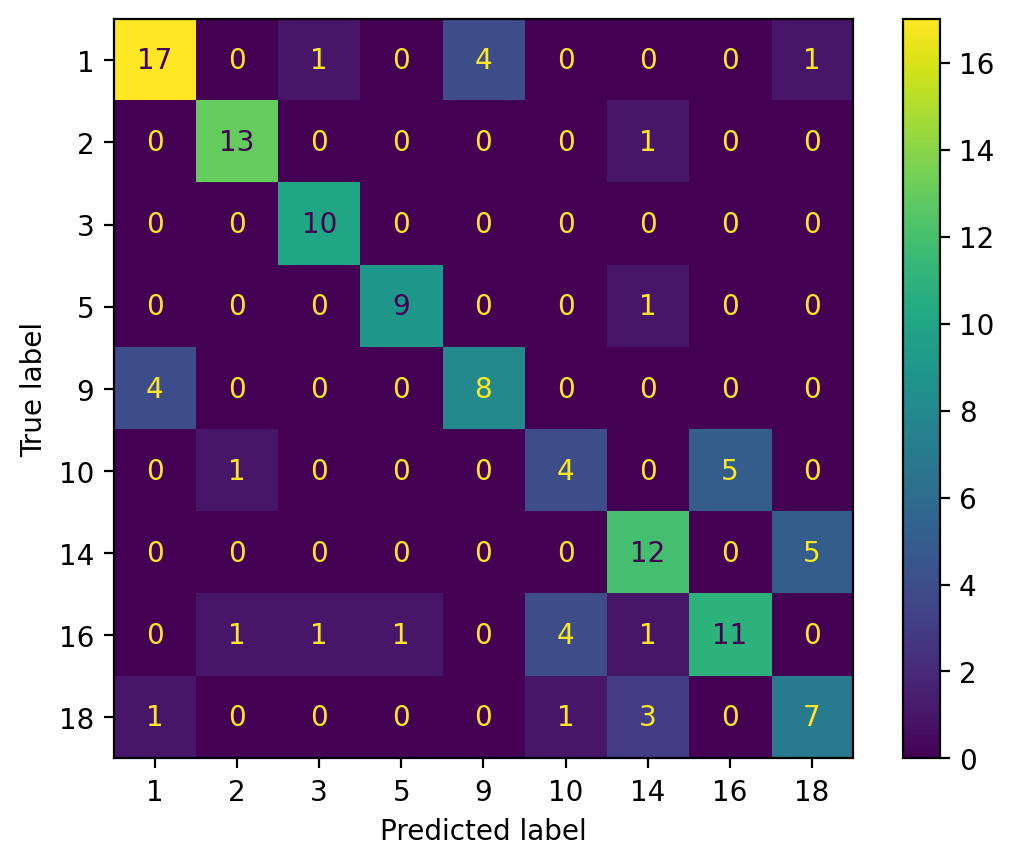

In [2]:
run_ModelBasedAI_experiment("tab")

Precision Micro: 0.720588
Precision Macro: 0.719159
Precision Weighted: 0.728147
Std. Deviation: 0.1477
Recall Macro: 0.715349
Recall Micro: 0.720588
Recall Weighted: 0.720588
F1 score Weighted: 0.715653
F1 score Macro: 0.703654
F1 score Micro: 0.720588


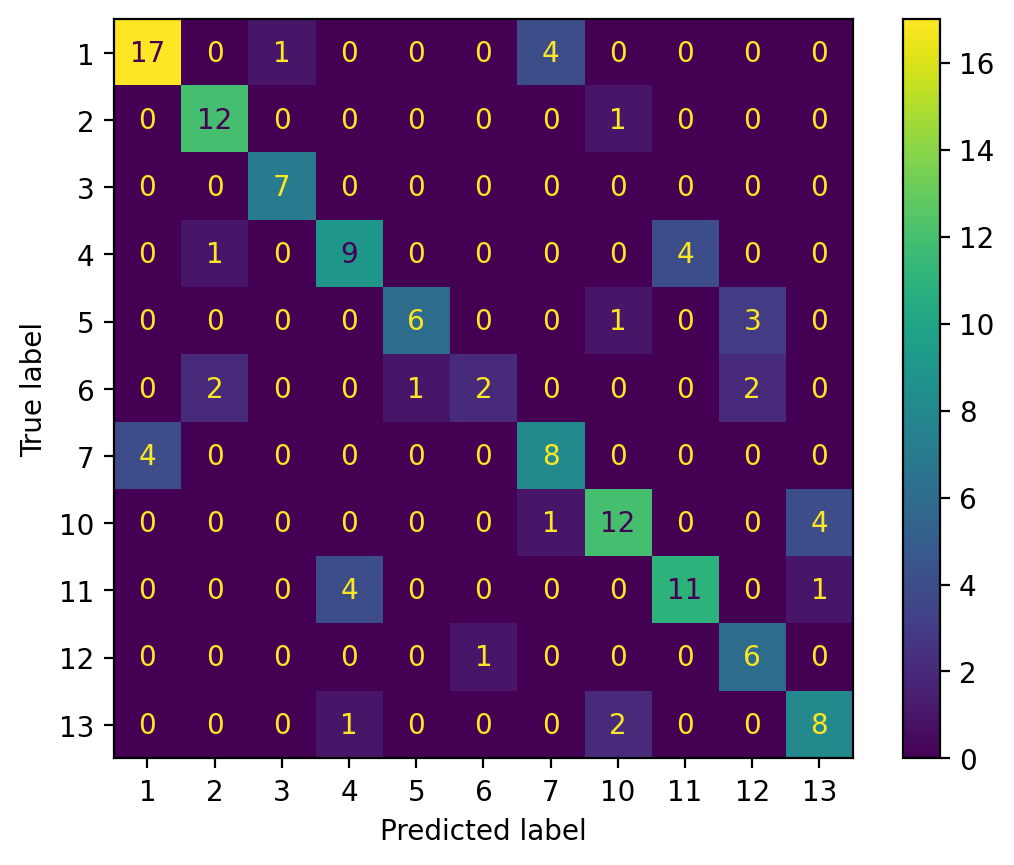

In [3]:
run_ModelBasedAI_experiment("nawba")

# Traditional ML models

## K-Neirest Neighbrours (KNN)

For [tab]: Stride 0.5% || Length of 1024 notes
Done with fold:  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 --------------------
Precision Micro: 0.866328
Precision Macro: 0.880886
Precision Weighted: 0.869092
Std. Deviation: 0.0940
Recall Macro: 0.841705
Recall Micro: 0.866328
Recall Weighted: 0.866328
F1 score Weighted: 0.864590
F1 score Macro: 0.853934
F1 score Micro: 0.866328
Recall_std  0.0892152126174502
f1_std  0.0887805506134671


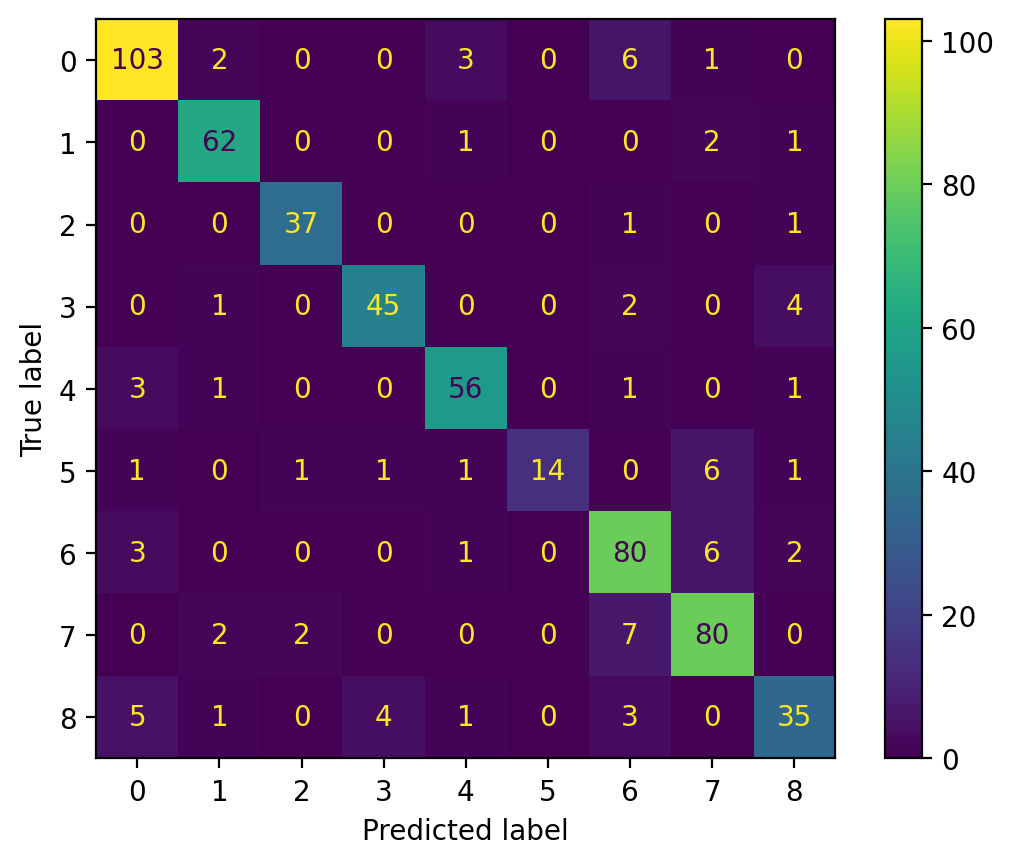

In [3]:
_, __, ___ = run_KNN_experiment("tab", overlap = 0.5, sequence_length = 1024, random_state = 42)

## Support Vector Classifier (SVC)

For [tab]: Stride 0.5% || Length of 256 notes
Done with fold:  0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 --------------------
Precision Micro: 0.861154
Precision Macro: 0.855040
Precision Weighted: 0.859035
Std. Deviation: 0.0730
Recall Macro: 0.828814
Recall Micro: 0.861154
Recall Weighted: 0.861154
F1 score Weighted: 0.856794
F1 score Macro: 0.835885
F1 score Micro: 0.861154
Recall_std  0.06925678909006217
f1_std  0.0838946475922803


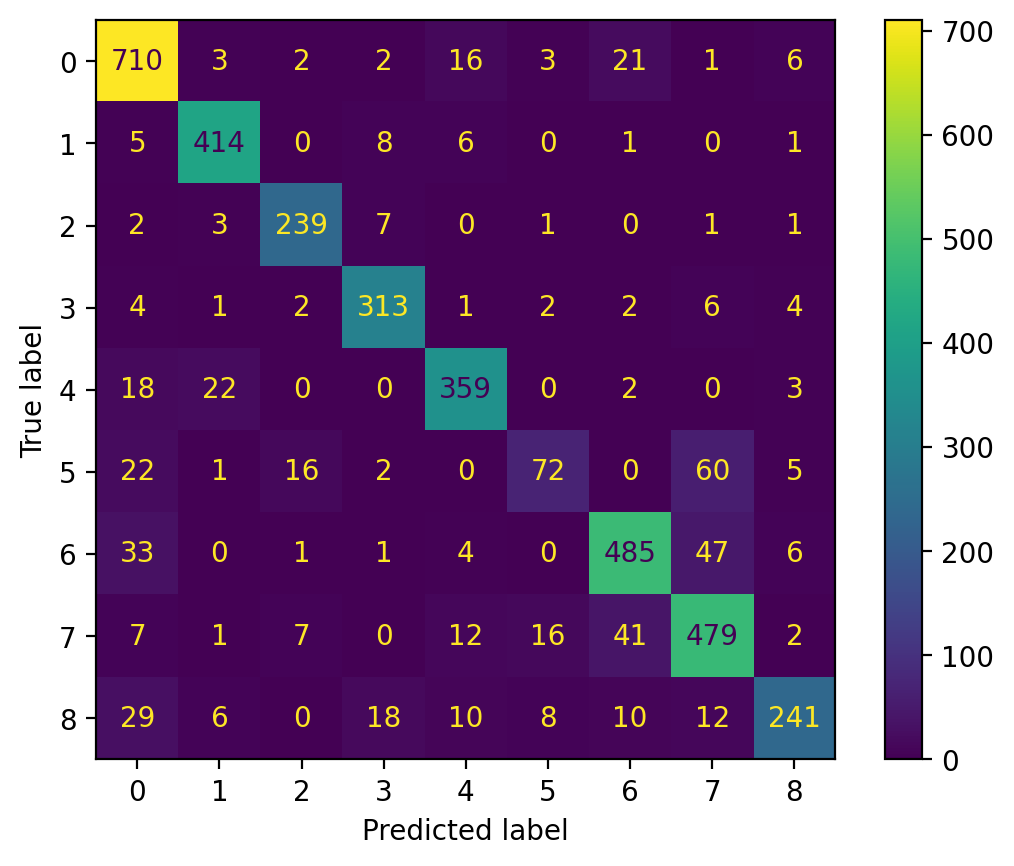

In [4]:
_, __, ___ = run_SVC_experiment("tab", overlap = 0.5, sequence_length = 256, random_state = 42)

## Random Forest Classifier (RF)

For [tab]: Stride 0.5% || Length of 256 notes
 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
 --------------------
Precision Micro: 0.835153
Precision Macro: 0.835168
Precision Weighted: 0.833449
Std. Deviation: 0.0569
Recall Macro: 0.793186
Recall Micro: 0.835153
Recall Weighted: 0.835153
F1 score Weighted: 0.826821
F1 score Macro: 0.798823
F1 score Micro: 0.835153
Recall_std  0.05394213880764949
f1_std  0.07141075814196246


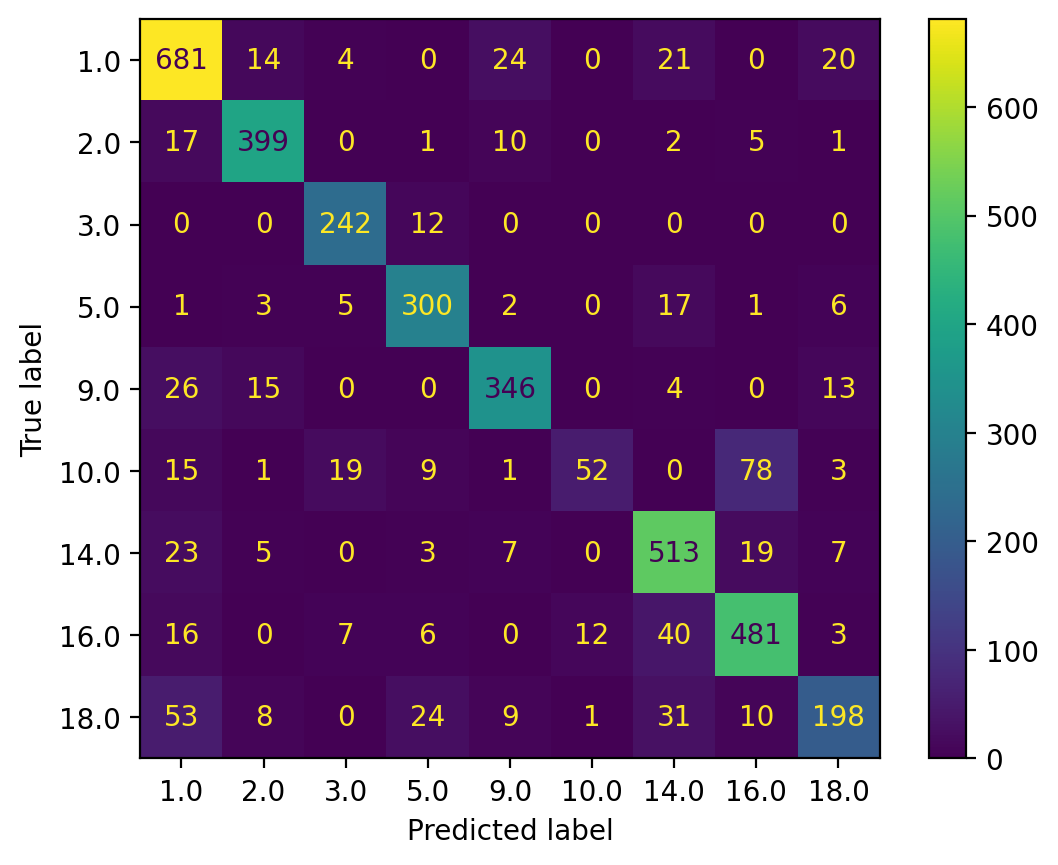

In [5]:
_, __, ___ = run_RandomForest_experiment("tab", overlap = 0.5, sequence_length = 256, random_state = 42)

In [ ]:
display_featrue_importance_rf()

# Deep Learning models

## 1D-Conolutional Neural Network (1DCNN)

In [ ]:
_, __, ___ = run_1DCNN_experiment("tab", overlap = 0.5, sequence_length = 512, random_state = 42, batch_size = 16, folds = 10)

For [tab]: Stride 0.5% || Length of 512 notes, 16
Processing fold:Fold 0:
Finished at epoch 23
Got 159 / 177 correct with accuracy 89.83
Fold 1:


## Long Short-Term Memory Neural Network (LSTM)

In [ ]:
_, __, ___ = run_RNN_experiment("tab", overlap = 0.5, sequence_length = 512, hidden_size = 128, num_layers = 4, random_state = 42, batch_size = 16, folds = 10)

## Graph Convolutional Neural Network (GNN)

In [ ]:
_, __, ___ = run_GNN_experiment("tab", subgraph_size=  128, num_hidden_features = 128, random_state=42, num_layers=2, dropout=0.7, batch_size=16)

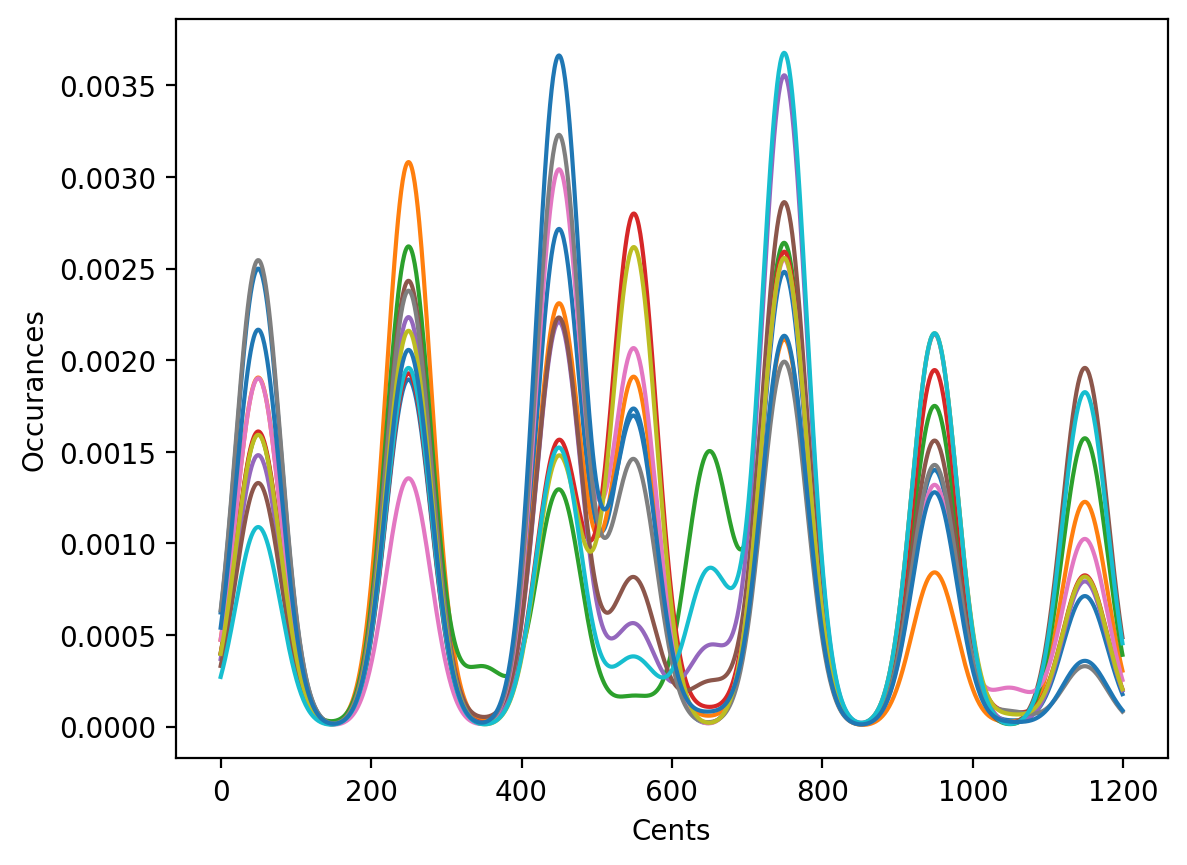

In [ ]:
# DO NOT RUN
for model in models:
    plt.xlabel("Cents")
    plt.ylabel("Occurances")
    plt.plot(model)